In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly.express as ex


In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [ ]:
dataset=spark.read.csv("BankChurners.csv",inferSchema=True, header =True)

In [ ]:
dataset.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

# **Dataset** **Overview**

In [ ]:
print('Data overview')
dataset.printSchema()
print('Columns overview')
pd.DataFrame(dataset.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ra

,Column Name,Data type
0,CLIENTNUM,int
1,Attrition_Flag,string
2,Customer_Age,int
3,Gender,string
4,Dependent_count,int
5,Education_Level,string
6,Marital_Status,string
7,Income_Category,string
8,Card_Category,string
9,Months_on_book,int


In [ ]:
print('Data frame describe (string and numeric columns only):')
dataset.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,count,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127
1,mean,7.391776063336625E8,None,46.32596030413745,None,2.3462032191172115,None,None,None,None,35.928409203120374,3.8125802310654686,2.3411671768539546,2.4553174681544387,8631.953698034848,1162.8140614199665,7469.139636614887,0.7599406536980376,4404.086303939963,64.85869457884863,0.7122223758269962,0.2748935518909845,0.1599974639787803,0.8400025708403275
2,stddev,3.690378345023116E7,None,8.016814032549046,None,1.29890834890379,None,None,None,None,7.98641633087208,1.55440786533883,1.0106223994182844,1.1062251426359249,9088.776650223148,814.9873352357533,9090.685323679114,0.2192067692307027,3397.129253557085,23.47257044923301,0.23808609133294137,0.27569146925238736,0.36530101238046947,0.36530103711017936
3,min,708082083,Attrited Customer,26,F,0,College,Divorced,$120K +,Blue,13,1,0,0,1438.3,0,3.0,0.0,510,10,0.0,0.0,7.6642E-6,4.1998E-4
4,max,828343083,Existing Customer,73,M,5,Unknown,Unknown,Unknown,Silver,56,6,6,6,34516.0,2517,34516.0,3.397,18484,139,3.714,0.999,0.99958,0.99999


In [ ]:
print(f'There are total {dataset.count()} rows, Let us print first 2 data rows:')
dataset.limit(2).toPandas()

There are total 10127 rows, Let us print first 2 data rows:


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994


In [ ]:
#in data description, it says ignore last 2 columns
#So, I am dropping last 2 columns
dataset=dataset.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2')

In [ ]:
#Converting Python Dataset to Pandas
df=dataset.toPandas()

In [ ]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Checking for null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int32  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int32  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int32  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int32  
 10  Total_Relationship_Count  10127 non-null  int32  
 11  Months_Inactive_12_mon    10127 non-null  int32  
 12  Contacts_Count_12_mon     10127 non-null  int32  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [ ]:
#Converting Dataset to Pandas Dataframe
df=dataset.toPandas()
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# Exploratory Data Analysis

In [ ]:

ex.pie(df,names='Attrition_Flag',title='Proportion of churn vs not churn customers',hole=0.33)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



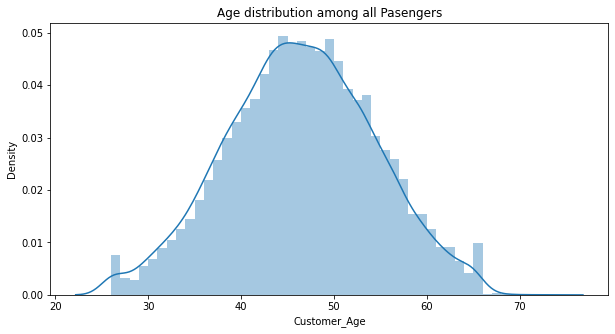

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Age distribution among all Pasengers')
sns.distplot(df['Customer_Age']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



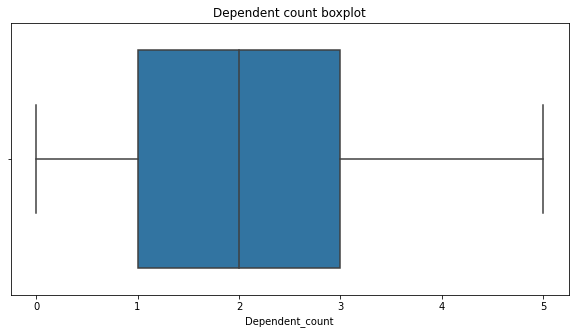

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Dependent count boxplot')
sns.boxplot(df['Dependent_count']);

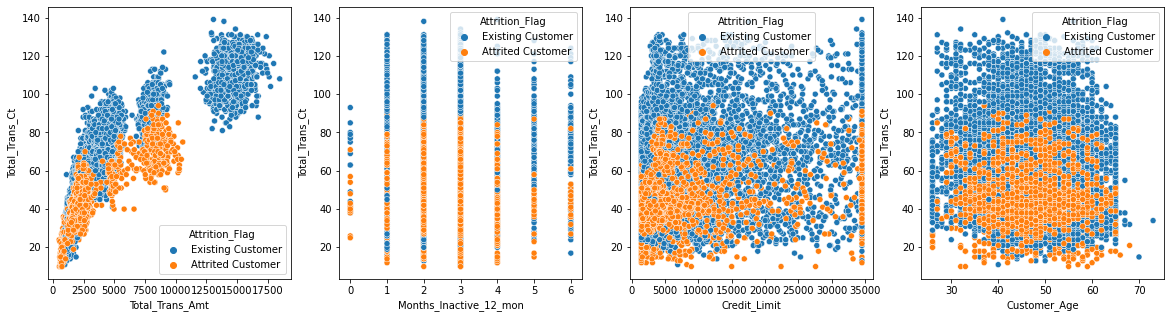

In [ ]:
df_frequency=pd.concat([df['Customer_Age'],df['Total_Trans_Ct'],df['Total_Trans_Amt'],df['Months_Inactive_12_mon'],df['Credit_Limit'],df['Attrition_Flag']],axis=1)
fig,ax=plt.subplots(ncols=4,figsize=(20,5))
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Total_Trans_Amt",hue="Attrition_Flag",ax=ax[0])
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Months_Inactive_12_mon",hue="Attrition_Flag",ax=ax[1])
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Credit_Limit",hue="Attrition_Flag",ax=ax[2])
_scat=sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Customer_Age",hue="Attrition_Flag",ax=ax[3])

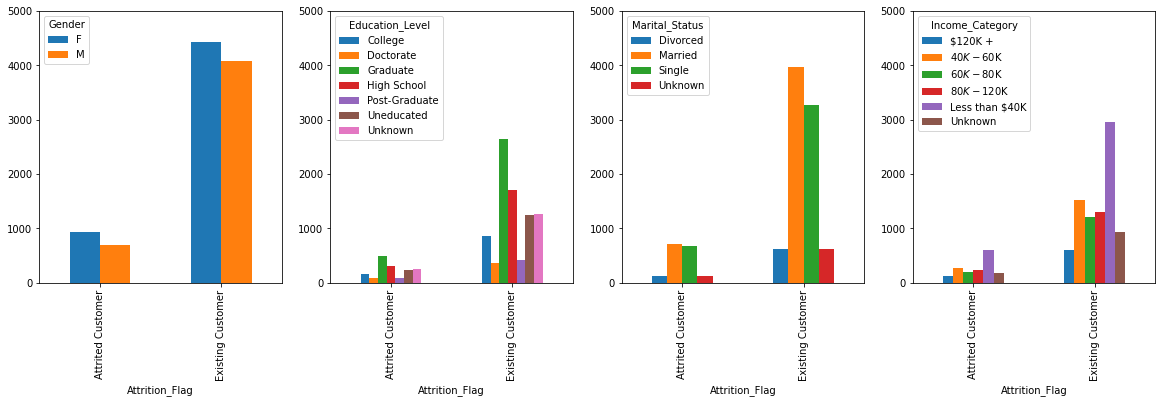

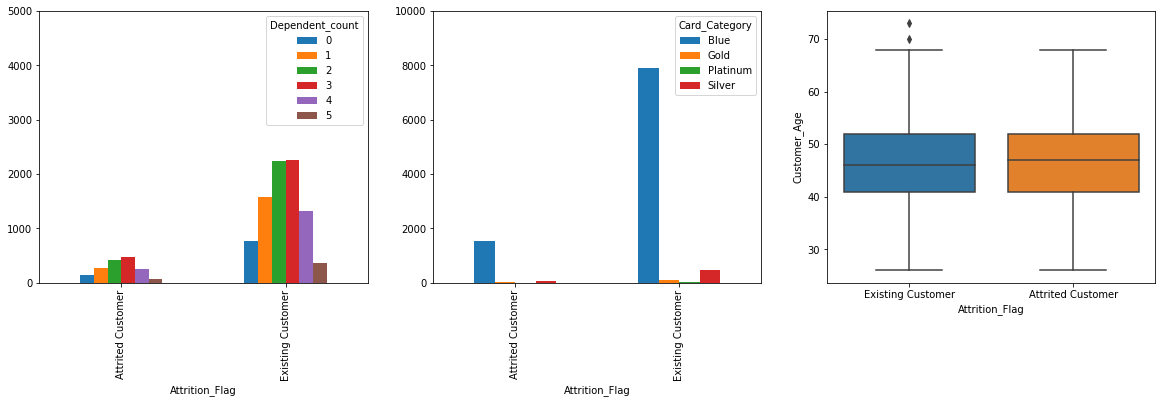

In [ ]:
df_demographic=pd.concat([df['Customer_Age'],df['Gender'],df['Education_Level'],df['Marital_Status'],
                          df['Income_Category'],df['Attrition_Flag']],axis=1)
fig,(ax, ax2, ax3, ax4)=plt.subplots(ncols=4,figsize=(20,5))
pd.crosstab(df['Attrition_Flag'],df['Gender']).plot(kind='bar',ax=ax, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Education_Level']).plot(kind='bar',ax=ax2, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Marital_Status']).plot(kind='bar',ax=ax3, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Income_Category']).plot(kind='bar',ax=ax4, ylim=[0,5000])

fig,(ax, ax2, ax3)=plt.subplots(ncols=3,figsize=(20,5))
pd.crosstab(df['Attrition_Flag'],df['Dependent_count']).plot(kind='bar',ax=ax, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Card_Category']).plot(kind='bar',ax=ax2, ylim=[0,10000])
_box=sns.boxplot(data = df_demographic,x='Attrition_Flag',y='Customer_Age', ax=ax3)

# **Correlation**

In [ ]:
categorical_features = [t[0] for t in dataset.dtypes if t[1]=='string']
df_cat_fea=dataset.select(categorical_features)
df_cat_fea.describe().show()
df_cat_fea=df_cat_fea.toPandas()


+-------+-----------------+------+---------------+--------------+---------------+-------------+
|summary|   Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|
+-------+-----------------+------+---------------+--------------+---------------+-------------+
|  count|            10127| 10127|          10127|         10127|          10127|        10127|
|   mean|             null|  null|           null|          null|           null|         null|
| stddev|             null|  null|           null|          null|           null|         null|
|    min|Attrited Customer|     F|        College|      Divorced|        $120K +|         Blue|
|    max|Existing Customer|     M|        Unknown|       Unknown|        Unknown|       Silver|
+-------+-----------------+------+---------------+--------------+---------------+-------------+



In [ ]:
numeric_features = [t[0] for t in dataset.dtypes if t[1] == 'int' or t[1] =='double']
df_num_fea=dataset.select(numeric_features)
df_num_fea.describe().show()
df_num_fea=df_num_fea.toPandas()

+-------+-------------------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|summary|          CLIENTNUM|     Customer_Age|   Dependent_count|    Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|   Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+-------------------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|  count|              10127|            10127|             10127| 

In [ ]:
df_num_fea['Attrition_Flag']=df.loc[:,'Attrition_Flag']
oh=pd.get_dummies(df_num_fea['Attrition_Flag'])
df_num_fea=df_num_fea.drop(['Attrition_Flag'],axis=1)
df_num_fea=df_num_fea.drop(['CLIENTNUM'],axis=1)
df_num_fea=df_num_fea.join(oh)
df_num_fea.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrited Customer,Existing Customer
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,1
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1


In [ ]:
df_num_fea.corr(method='pearson')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrited Customer,Existing Customer
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,0.018203,-0.018203
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,0.018991,-0.018991
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,0.013687,-0.013687
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663,-0.150005,0.150005
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503,0.152449,-0.152449
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471,0.204491,-0.204491
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965,-0.023873,0.023873
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022,-0.263053,0.263053
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808,-0.000285,0.000285
Total_Amt_Chng_Q4_Q1,-0.062042,-0.035439,-0.048959,0.050119,-0.032247,-0.024445,0.012813,0.058174,0.007595,1.000000,0.039678,0.005469,0.384189,0.035235,-0.131063,0.131063


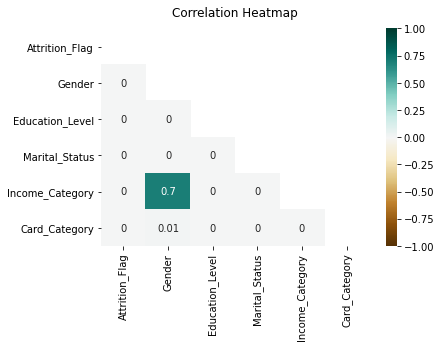

In [ ]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
df_categorical_encoded = pd.DataFrame() 

for i in df_cat_fea.columns :
  df_categorical_encoded[i]=label.fit_transform(df_cat_fea[i])

from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in df_categorical_encoded:
  col = []
  for var2 in df_categorical_encoded :
    cramers =cramers_V(df_categorical_encoded[var1], df_categorical_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cramerv_matrix = pd.DataFrame(cramers_results, columns = df_categorical_encoded.columns, index =df_categorical_encoded.columns)
mask = np.triu(np.ones_like(cramerv_matrix, dtype=np.bool))
cat_heatmap = sns.heatmap(cramerv_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
cat_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We see here that the categorical columns are NOT CORRELATED with customer churn by themselves. This supports the previous figures that show similar distribution between existing and churned customers across all demographic. Building an accurate model without considering the numerical values is impossible.

Now let's check the correlation of the numerical values.

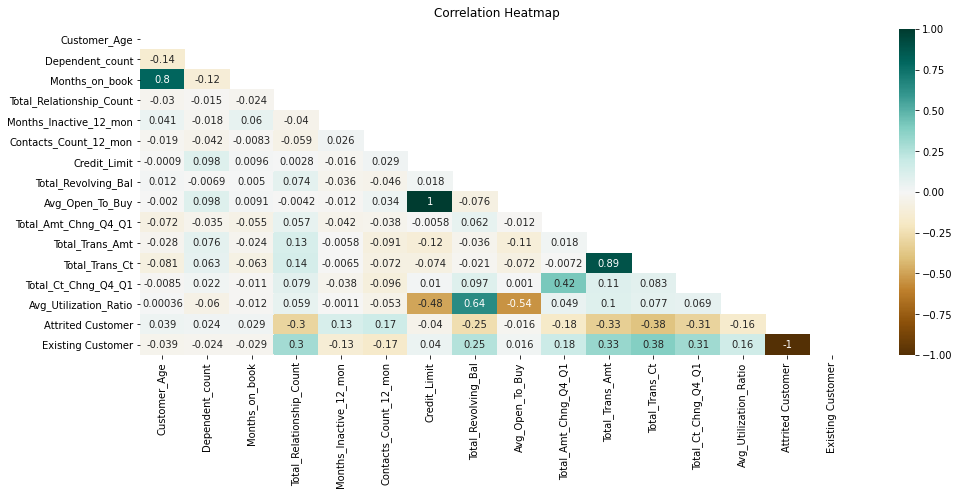

In [ ]:
##Point Biserial Correlation
from scipy import stats
num_corr=df_num_fea.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=np.bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
num_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We now see better correlation measurements to the customer churn. In the heatmap above, the correlation coefficient of attrited and existing customer to all feature columns are identical in numbers, with mirroring signs (+ and -). Let's view them better:

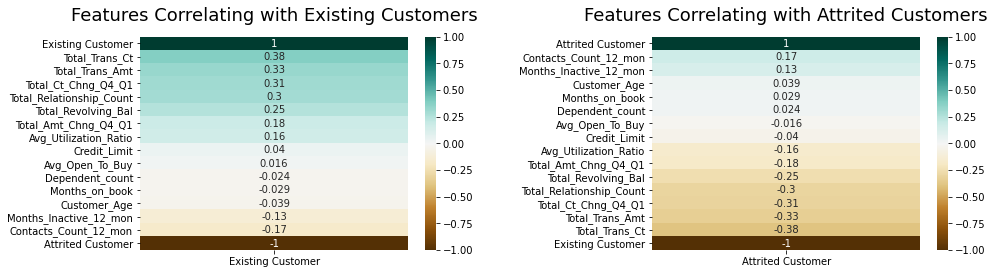

In [ ]:
fig, ax=plt.subplots(ncols=2,figsize=(15, 5))

heatmap = sns.heatmap(num_corr[['Existing Customer']].sort_values(by='Existing Customer', ascending=False), ax=ax[0],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Existing Customers', fontdict={'fontsize':18}, pad=16);
heatmap = sns.heatmap(num_corr[['Attrited Customer']].sort_values(by='Attrited Customer', ascending=False), ax=ax[1],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Attrited Customers', fontdict={'fontsize':18}, pad=16);

fig.tight_layout(pad=5)

We see above that the following features are not correlated with customer churn (between -0.1 and +0.1) :

Credit Limit

Average Open To Buy

Months On Book

Age

Dependent Count

In [ ]:
# Droping CLIENTNUM columns because Client number is unique identifier for the customer holding the account
# So this number doesn't really effect our churn prediction.
dataset=dataset.drop('CLIENTNUM','Credit_Limit','Avg_Open_To_Buy','Months_on_book','Dependent_count','Customer_Age')

In [ ]:
df=dataset.toPandas()

# **String Indexing**

In [ ]:
SI_att_flag = StringIndexer(inputCol="Attrition_Flag", outputCol="Attrition_Flag_encoding")
dataset = SI_att_flag.fit(dataset).transform(dataset)

SI_Gender = StringIndexer(inputCol="Gender", outputCol="Gender_encoding")
dataset = SI_Gender.fit(dataset).transform(dataset)

SI_Education_Level = StringIndexer(inputCol="Education_Level", outputCol="Education_Level_encoding")
dataset = SI_Education_Level.fit(dataset).transform(dataset)

SI_Marital_Status = StringIndexer(inputCol="Marital_Status", outputCol="Marital_Status_encoding")
dataset = SI_Marital_Status.fit(dataset).transform(dataset)

SI_Income_Category = StringIndexer(inputCol="Income_Category", outputCol="Income_Category_encoding")
dataset = SI_Income_Category.fit(dataset).transform(dataset)

SI_Card_Category = StringIndexer(inputCol="Card_Category", outputCol="Card_Category_encoding")
dataset = SI_Card_Category.fit(dataset).transform(dataset)


dataset.show(30)

+-----------------+------+---------------+--------------+---------------+-------------+------------------------+----------------------+---------------------+-------------------+--------------------+---------------+--------------+-------------------+---------------------+-----------------------+---------------+------------------------+-----------------------+------------------------+----------------------+
|   Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Total_Revolving_Bal|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag_encoding|Gender_encoding|Education_Level_encoding|Marital_Status_encoding|Income_Category_encoding|Card_Category_encoding|
+-----------------+------+---------------+--------------+---------------+-------------+------------------------+----------------------+---------------------+-------------------+-----

# **Vector Assembler**

In [ ]:
# Assemble all the features with VectorAssembler

required_features = ['Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
                     'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt',
                     'Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio',
                     'Gender_encoding','Education_Level_encoding', 'Marital_Status_encoding',
                     'Income_Category_encoding','Card_Category_encoding'
                   ]

assembler = VectorAssembler(inputCols=required_features, outputCol='Outcome')

transformed_data = assembler.transform(dataset)

transformed_data.show()

+-----------------+------+---------------+--------------+---------------+-------------+------------------------+----------------------+---------------------+-------------------+--------------------+---------------+--------------+-------------------+---------------------+-----------------------+---------------+------------------------+-----------------------+------------------------+----------------------+--------------------+
|   Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Total_Revolving_Bal|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag_encoding|Gender_encoding|Education_Level_encoding|Marital_Status_encoding|Income_Category_encoding|Card_Category_encoding|             Outcome|
+-----------------+------+---------------+--------------+---------------+-------------+------------------------+----------------------+-----

# **Scaling**

In [ ]:
# StandardScaler
scaler = StandardScaler(inputCol="Outcome", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(transformed_data)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(transformed_data)
scaledData.show()

+-----------------+------+---------------+--------------+---------------+-------------+------------------------+----------------------+---------------------+-------------------+--------------------+---------------+--------------+-------------------+---------------------+-----------------------+---------------+------------------------+-----------------------+------------------------+----------------------+--------------------+--------------------+
|   Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Total_Revolving_Bal|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag_encoding|Gender_encoding|Education_Level_encoding|Marital_Status_encoding|Income_Category_encoding|Card_Category_encoding|             Outcome|      scaledFeatures|
+-----------------+------+---------------+--------------+---------------+-------------+-----------

Since the data set is highly skewed – we have much more Negative training samples than Positive training samples – we will need to try out some strategies that counter the unbalance.

Here I'm going to use one of the simplest method called down-samplings, which means we just randomly filter out some of the majority cases.

# **Down Sampling**

In [ ]:
scaledData.select("Attrition_Flag_encoding").groupBy("Attrition_Flag_encoding").count().collect()

[Row(Attrition_Flag_encoding=0.0, count=8500),
 Row(Attrition_Flag_encoding=1.0, count=1627)]

In [ ]:
# Down-sampling
scaledData_ds, _ = scaledData.filter(scaledData["Attrition_Flag_encoding"] == 0.0).randomSplit([0.4, 0.6])
scaledData_ds = scaledData.filter(scaledData["Attrition_Flag_encoding"] == 1.0).union(scaledData_ds)
scaledData_ds.select("Attrition_Flag_encoding").groupBy("Attrition_Flag_encoding").count().collect()

[Row(Attrition_Flag_encoding=0.0, count=3434),
 Row(Attrition_Flag_encoding=1.0, count=1627)]

# **Test and Train Data**

In [ ]:
# Split the data
(training_data, test_data) = scaledData_ds.randomSplit([0.8,0.2], seed=1)

# **Random Forest Classifier**

In [ ]:
#Define the model
rf = RandomForestClassifier(labelCol='Attrition_Flag_encoding', 
                            featuresCol='scaledFeatures',
                            maxDepth=5)

# Fit the model
model = rf.fit(training_data)
# Predict with the test dataset
rf_predictions = model.transform(test_data)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


multi_evaluator_a = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator_a.evaluate(rf_predictions))

multi_evaluator_p = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'weightedPrecision')
print('Random Forest classifier Precision:', multi_evaluator_p.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.9042769857433809
Random Forest classifier Precision: 0.903524766986527


In [ ]:
# Predict with the test dataset
rf_predictions = model.transform(test_data)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


multi_evaluator_a = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator_a.evaluate(rf_predictions))

multi_evaluator_p = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'weightedPrecision')
print('Random Forest classifier Precision:', multi_evaluator_p.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.9042769857433809
Random Forest classifier Precision: 0.903524766986527


# **Evaluating ROC metric**

In [ ]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = rf_predictions.select(['probability', 'Attrition_Flag_encoding'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.9631368260819305


# **Visualising AUC Metrics**

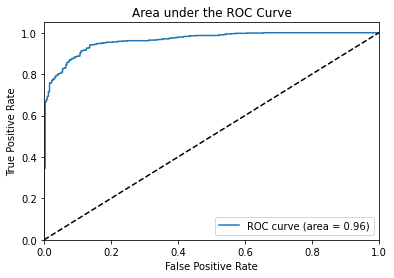

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'Attrition_Flag_encoding', maxDepth = 3)
dtModel = dt.fit(training_data)
dt_predictions = dtModel.transform(test_data)



Decision Tree Accuracy: 0.8767820773930753
Decision Tree Precision: 0.8757127376931148


In [ ]:
multi_evaluator_a = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator_a.evaluate(dt_predictions))
multi_evaluator_p = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', 
                                                      metricName = 'weightedPrecision')
print('Decision Tree Accuracy:', multi_evaluator_p.evaluate(dt_predictions))

Decision Tree Accuracy: 0.8953662182361734
Decision Tree Accuracy: 0.8936588486502712


# **Evaluating ROC metric**

In [ ]:
results = dt_predictions.select(['probability', 'Attrition_Flag_encoding'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.8986666152838261


# **Visualising AUC Metrics**

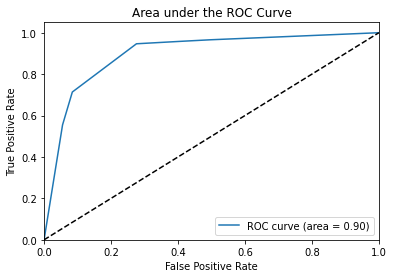

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'Attrition_Flag_encoding', maxIter=10)
lrModel = lr.fit(training_data)
lr_predictions = dtModel.transform(test_data)



Logistic Regression Accuracy: 0.8767820773930753
Logistic Regression Precision: 0.8757127376931148


In [ ]:
multi_evaluator_a = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator_a.evaluate(lr_predictions))

multi_evaluator_p = MulticlassClassificationEvaluator(labelCol = 'Attrition_Flag_encoding', metricName = 'weightedPrecision')
print('Logistic Regression Precision:', multi_evaluator_p.evaluate(lr_predictions))


Logistic Regression Accuracy: 0.8953662182361734
Logistic Regression Accuracy: 0.8953662182361734


# **Evaluating ROC metric**

In [ ]:
results = lr_predictions.select(['probability', 'Attrition_Flag_encoding'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.8986666152838261


# **Visualising AUC Metrics**

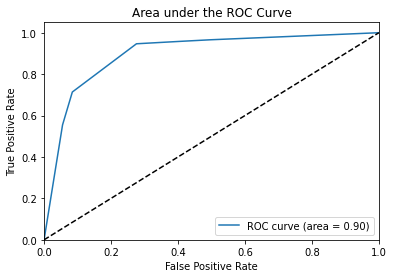

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()